In [1]:
# import 
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
# Check if CUDA is available
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')# Check if CUDA is available
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/dcase-aml/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using cuda device
Using cuda device
Running on Kaggle


In [2]:
# Check if CUDA is available
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## Data Loading 


In [3]:
TRAIN_PATH = DATA_PATH + r"dev_data/dev_data/slider/train"
TEST_PATH = DATA_PATH +r"dev_data/dev_data/slider/test"

In [4]:
import librosa
import os
from torch.utils.data import Dataset
from librosa.feature import melspectrogram
import numpy as np
class AudioDataset(Dataset):
    def __init__(self, data_path, train):
        self.data_path = data_path
        if train:
            self.labels = [0 * len(os.listdir(self.data_path))]
        else:
            self.labels = [1 if el[0]=='a' else 0 for el in os.listdir(self.data_path)]
        print(self.data_path)
        self.audios, self.srs= zip(*[librosa.load(os.path.join(self.data_path, path)) for path in os.listdir(self.data_path)])
        self.mfccs = [librosa.feature.mfcc(y=audio, sr=self.srs[0]) for audio in self.audios]
        self.s= melspectrogram(y=self.audios[0], sr=self.srs[0])
        print(self.s.shape)
        self.spectrograms = [melspectrogram(y=audio, sr=self.srs[0]) for audio in self.audios]
        print(self.spectrograms[0].shape)
        self.spectrograms_db = [librosa.amplitude_to_db(spec, ref=np.min) for spec in self.spectrograms]
        print(self.spectrograms_db[0].shape)
    def __len__(self):
        return len(os.listdir(self.data_path))

    def __getitem__(self, idx):
        audio = self.audios[idx]
        label = self.labels[idx]
        sr = self.srs[idx]
        mfcc = self.mfccs[idx]
        spec = self.spectrograms[idx]
        spec_db = self.spectrograms_db[idx]
        return spec, spec_db, label

In [5]:
train_dataset = AudioDataset(data_path=TRAIN_PATH, train=True)
test_dataset = AudioDataset(data_path=TEST_PATH, train=False)
train_dataset.spectrograms[0].shape

/kaggle/input/dcase-aml/dev_data/dev_data/slider/train
(128, 431)
(128, 431)
(128, 431)
/kaggle/input/dcase-aml/dev_data/dev_data/slider/test
(128, 431)
(128, 431)
(128, 431)


(128, 431)

## Model 


In [28]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 28*28),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [29]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


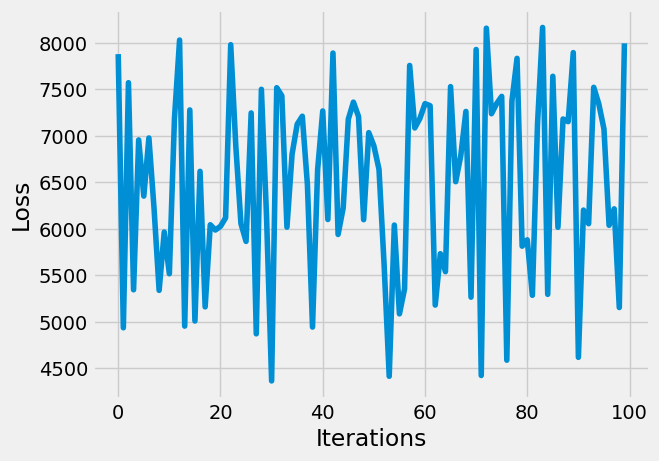

In [31]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for image in train_dataset.spectrograms_db:
        
       # Reshaping the image to (-1, 784)
       image = np.resize(image,(1,28*28)) #mput 256 x 256 and put convolutional layers
       # Output of Autoencoder
       image = torch.from_numpy(image)
       reconstructed = model(image)

       # Calculating the loss function
       loss = loss_function(reconstructed, image)

       # The gradients are set to zero,
       # the gradient is computed and stored.
       # .step() performs parameter update
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       # Storing the losses in a list for plotting
       losses.append(loss)
    outputs.append((epochs, image, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([loss.detach().numpy() for loss in losses[-100:]])



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

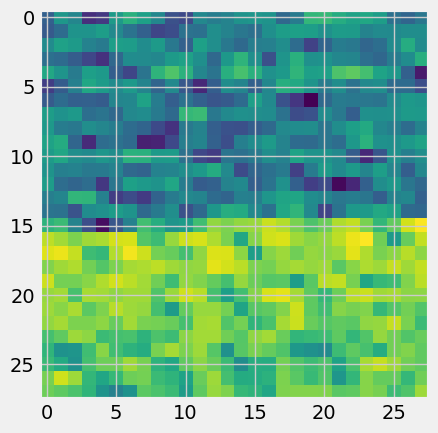

In [35]:
for i, item in enumerate(image):

   # Reshape the array for plotting
   item = item.reshape(-1, 28, 28)
   plt.imshow(item[0])

   for i, item in enumerate(reconstructed):
     item = item.reshape(-1, 28, 28)
     plt.imshow(item[0])
